In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

In [13]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15,15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [14]:
kickstarter = pd.read_csv('kickstarter_04_25_19_ready_for_modeling.csv')

In [15]:
X = kickstarter[['goal', 'staff_pick_True',
       'cam_length', 'blurb_length', 'country_US', 'main_category_comics',
       'main_category_crafts', 'main_category_dance', 'main_category_design',
       'main_category_fashion', 'main_category_film & video',
       'main_category_food', 'main_category_games', 'main_category_journalism',
       'main_category_music', 'main_category_photography',
       'main_category_publishing', 'main_category_technology',
       'main_category_theater']]
y = kickstarter['state_successful']

In [16]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
X_mid, X_test, y_mid, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify = y)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_mid, y_mid, test_size=0.25, random_state=42, stratify = y_mid)

### XGBoost ###

In [19]:
xgBoost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
xgBoost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
xgBoost_pred = xgBoost.predict(X_val)

In [22]:
print('XGBoost Results:')
print(confusion_matrix(y_val, xgBoost_pred))
print(classification_report(y_val, xgBoost_pred))
print('XGBoost score: %f' % xgBoost.fit(X_train, y_train).score(X_val, y_val))

XGBoost Results:
[[12051  6935]
 [ 4623 17801]]
              precision    recall  f1-score   support

           0       0.72      0.63      0.68     18986
           1       0.72      0.79      0.75     22424

   micro avg       0.72      0.72      0.72     41410
   macro avg       0.72      0.71      0.72     41410
weighted avg       0.72      0.72      0.72     41410

XGBoost score: 0.720889


In [23]:
xgBoost_y_score = xgBoost.predict_proba(X_val)[:, 1]

In [24]:
xgBoost_fpr, xgBoost_tpr, auc_thresholds = roc_curve(y_val, xgBoost_y_score)
roc_auc_xgBoost = auc(xgBoost_fpr, xgBoost_tpr)
print(auc(xgBoost_fpr, xgBoost_tpr))

0.7912842668982786


In [25]:
xgBoost_pred_test = xgBoost.predict(X_test)

In [26]:
xgBoost.predict([-0.03639885, -0.37481072, -0.24414886, -0.04240935,  0.56599264,
       -0.21773993, -0.15281895, -0.10589387, -0.17668643, -0.26982191,
       -0.40234887, -0.29229358, -0.25988079, -0.1363122 , -0.4128152 ,
       -0.17738287, -0.30923274, -0.36534622,  5.3262231 ])

array([1])

In [27]:
print('XGBoost Results:')
print(confusion_matrix(y_test,xgBoost_pred_test))
print(classification_report(y_test, xgBoost_pred_test))

XGBoost Results:
[[12019  6967]
 [ 4651 17773]]
              precision    recall  f1-score   support

           0       0.72      0.63      0.67     18986
           1       0.72      0.79      0.75     22424

   micro avg       0.72      0.72      0.72     41410
   macro avg       0.72      0.71      0.71     41410
weighted avg       0.72      0.72      0.72     41410



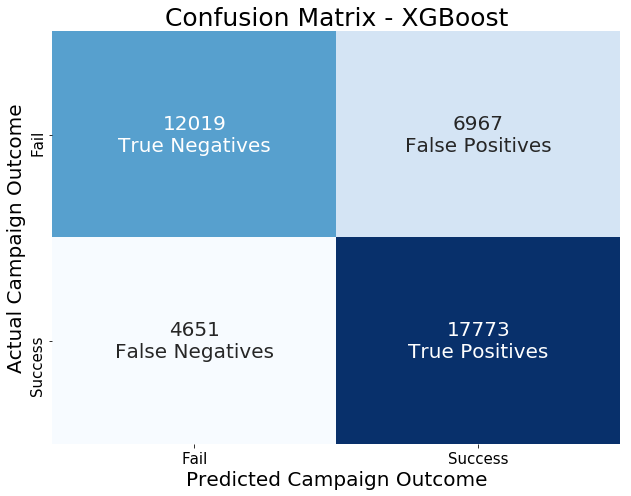

In [28]:
cm = confusion_matrix(y_test,xgBoost_pred_test)
plt.figure(figsize=(25,7))
plt.subplot(131)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 20}, fmt='g')
cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
    t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix - XGBoost', size=25)
plt.xlabel('Predicted Campaign Outcome', size=20)
plt.ylabel('Actual Campaign Outcome', size=20)
labels = ['Fail', 'Success']
ax.set_xticklabels(labels, size = 15)
ax.set_yticklabels(labels, size = 15)
plt.tight_layout()
#plt.savefig('Confusion_matrix_XGBoost.png')
#plt.savefig('Confusion_matrix_XGBoost.svg')
plt.show()

In [29]:
xgBoost_y_score_test = xgBoost.predict_proba(X_test)[:, 1]
xgBoost_fpr_test, xgBoost_tpr_test, xgBoost_auc_thresholds = roc_curve(y_test, xgBoost_y_score_test)
roc_auc_xgBoost_test = auc(xgBoost_fpr_test, xgBoost_tpr_test)
print(auc(xgBoost_fpr_test, xgBoost_tpr_test))

0.7895514054725867


In [ ]:
#pickling the model for the Flask app

In [31]:
#filename = 'finalized_xgBoost.sav'
#pickle.dump(xgBoost, open(filename, 'wb'))

In [34]:
#notes on how to load the model later:
# load the model from disk
#loaded_xgBoost = pickle.load(open('finalized_xgBoost.sav', 'rb'))
#result = loaded_xgBoost.score(X_test, y_test)
#print(result)